In [69]:
import os
import glob
import lsst.eotest.image_utils as imutils
import lsst.eotest.sensor as sensorTest
import lsst.eotest.raft as raft
import matplotlib.pyplot as plt
import numpy as np
import yaml

In [70]:
def gains(eotest_results_file):
    """
    Extract Fe55 gains from the results file of some eo testing.
    """
    results = sensorTest.EOTestResults(eotest_results_file)
    return {amp: gain for amp, gain in zip(results['AMP'], results['GAIN'])}

def load_ccob_config(config_file):
    """
    Loads ccob configuration (led, current, exp_time and positions)
    from a config yaml file
    """
    config = yaml.load(open(config_file))
    if 'path' not in config.keys(): config['path'] = './'
    if 'led_name' not in config.keys(): config['led_name'] = '*'
    if 'current' not in config.keys(): config['current'] = '*'
    if 'exp_time' not in config.keys(): config['exp_time'] = '*'
    if 'xpos' not in config.keys(): config['xpos'] = '*'
    if 'ypos' not in config.keys(): config['ypos']= '*'
    
    return config

def find_files(config):
    """
    Find all the files matching a given ccob configuration
    """
    f_pattern = os.path.join(config['path'], '*' + config['led_name'] + '*'
                             + config['current'] + '*' + config['exp_time'] + '*X'
                             + config['xpos'] + '*Y' + config['ypos'] + '*')
    return glob.glob(f_pattern)

def define_ccd_pos(ccd_pos_dict, raft_name, slot_names, xpos, ypos):
    ccd_pos_dict[raft_name] = {slot:[xpos[i],ypos[i]] for i,slot in enumerate(slot_names)}

In [71]:
config = load_ccob_config('ccob_config.yaml')
config

{'current': '0.012A',
 'eo_data_path': '/gpfs/slac/lsst/fs1/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-005/6288/collect_raft_results/v0/37124',
 'exp_time': '0.06s',
 'led_name': 'red',
 'path': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-005/171214/ccobxy',
 'tmp_dir': '/home/combet/tmp/',
 'xpos': '*',
 'ypos': '*'}

In [72]:
file_list = find_files(config)

In [73]:
file_list

['/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-005/171214/ccobxy/12_CCOB_red_0.012A_0.06s_X258_Y150_0000_20171215015049.fits',
 '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-005/171214/ccobxy/00_CCOB_red_0.012A_0.06s_X300_Y234_0000_20171215014154.fits',
 '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-005/171214/ccobxy/10_CCOB_red_0.012A_0.06s_X300_Y234_0000_20171215014154.fits',
 '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-005/171214/ccobxy/10_CCOB_red_0.012A_0.06s_X258_Y234_0000_20171215014518.fits',
 '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-005/171214/ccobxy/01_CCOB_red_0.012A_0.06s_X342_Y192_0000_20171215015708.fits',
 '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-005/171214/ccobxy/21_CCOB_red_0.012A_0.06s_X300_Y192_0000_20171215013334.fits',
 '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-005/171214/ccobxy/01_CCOB_red_0.012A_0.06s_X342_Y150_0000_20171215015344.fits',
 '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-005/171214/ccobxy/00_CCOB_red_0.012A_0.06s_X300_Y192_0000_20171215013334.fits',
 '/gpfs/slac/lsst/fs1/g/data/R_a

In [74]:
xpos = [258, 258, 258, 300, 300, 300, 342, 342, 342]
ypos = [234, 192, 150, 234, 192, 150, 234, 192, 150]
slot_names=['00','01','02','10','11','12','20','21','22']
ccd_pos_dict={}
define_ccd_pos(ccd_pos_dict, 'RTM-005', slot_names, xpos, ypos)

In [75]:
f_list = []
for i,slot in enumerate(slot_names):
    for f in file_list:
        flag1 = os.path.basename(f).startswith(slot)
        flag2 = 'X'+str(ccd_pos_dict['RTM-005'][slot][0]) in f  
        flag3 = 'Y'+str(ccd_pos_dict['RTM-005'][slot][1]) in f  
        flag = flag1 * flag2 * flag3
        if flag : f_list.append(f)

fits_files_dict={slot_names[i] : f_list[i] for i in range(len(f_list))}
fits_files_dict

{'00': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-005/171214/ccobxy/00_CCOB_red_0.012A_0.06s_X258_Y234_0000_20171215014518.fits',
 '01': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-005/171214/ccobxy/01_CCOB_red_0.012A_0.06s_X258_Y192_0000_20171215014750.fits',
 '02': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-005/171214/ccobxy/02_CCOB_red_0.012A_0.06s_X258_Y150_0000_20171215015049.fits',
 '10': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-005/171214/ccobxy/10_CCOB_red_0.012A_0.06s_X300_Y234_0000_20171215014154.fits',
 '11': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-005/171214/ccobxy/11_CCOB_red_0.012A_0.06s_X300_Y192_0000_20171215013334.fits',
 '12': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-005/171214/ccobxy/12_CCOB_red_0.012A_0.06s_X300_Y150_0000_20171215013741.fits',
 '20': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-005/171214/ccobxy/20_CCOB_red_0.012A_0.06s_X342_Y234_0000_20171215020016.fits',
 '21': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-005/171214/ccobxy/21_CCOB_red_0.012A_0.06s_X342_Y192_0000_201712

In [76]:
eo_data_path = '/gpfs/slac/lsst/fs1/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-005/6288/collect_raft_results/v0/37124'
ccd_dict={}
gains_dict={}
for slot in slot_names:
    bias_frames = glob.glob(os.path.join(config['path'], slot+'_Bias*'))
    mean_bias_file = slot+'_mean_bias_image.fits'
#    imutils.fits_mean_file(bias_frames, os.path.join(tmp_dir,mean_bias_file))
    ccd_dict[slot] = sensorTest.MaskedCCD(fits_files_dict[slot], bias_frame=os.path.join(config['tmp_dir'],mean_bias_file))
    print slot, ccd_dict[slot].md('LSST_NUM')
    eotest_results_file = os.path.join(eo_data_path, '{}_eotest_results.fits'.format(ccd_dict[slot].md('LSST_NUM')))
    gains_dict[slot] = gains(eotest_results_file)

00 E2V-CCD250-220
01 E2V-CCD250-239
02 E2V-CCD250-154
10 E2V-CCD250-165
11 E2V-CCD250-130
12 E2V-CCD250-153
20 E2V-CCD250-163
21 E2V-CCD250-216
22 E2V-CCD250-252


In [77]:
for slot in slot_names:
    outfile = os.path.join(config['tmp_dir'],'ccd' + slot + '_beam_reconstruction_'+config['led_name']+'.fits')
    image={}
    for amp in ccd_dict[slot]:
            image[amp] = ccd_dict[slot].bias_subtracted_image(amp)
            image[amp] *= gains_dict[slot][amp]
    imutils.writeFits({amp: image[amp].getImage() for amp in ccd_dict[slot]}, 
                      outfile, fits_files_dict[slot])


In [78]:
fits_files_dict_corr={slot : os.path.join(config['tmp_dir'],'ccd'+slot+'_beam_reconstruction_'+config['led_name']+'.fits') for slot in slot_names}
dd_corr = raft.RaftMosaic(fits_files_dict_corr, bias_subtract=False)

processing ccd02_beam_reconstruction_red.fits
processing ccd10_beam_reconstruction_red.fits
processing ccd00_beam_reconstruction_red.fits
processing ccd01_beam_reconstruction_red.fits
processing ccd20_beam_reconstruction_red.fits
processing ccd21_beam_reconstruction_red.fits
processing ccd22_beam_reconstruction_red.fits
processing ccd12_beam_reconstruction_red.fits
processing ccd11_beam_reconstruction_red.fits


8

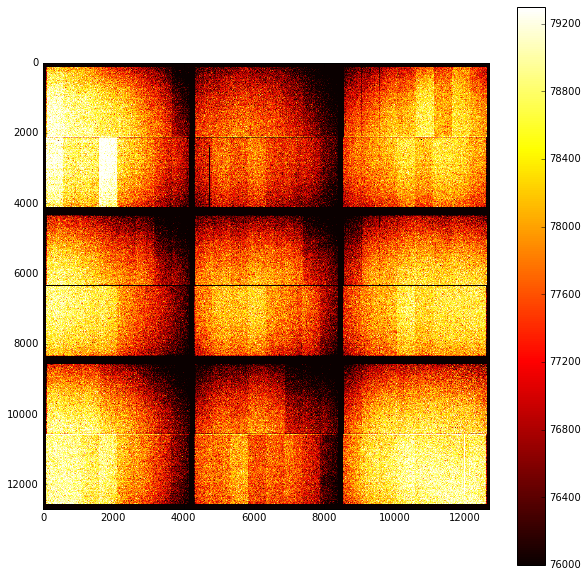

In [91]:
plt.imshow(dd_corr.image_array[:,::-1], vmin=76000, vmax=79300, cmap='hot')
plt.colorbar()


In [130]:
led_names = ['uv', 'blue', 'red', 'nm750', 'nm850','nm960']
avg = np.zeros((len(led_names),len(slot_names)))
for j,led in enumerate(led_names):
    for i,slot in enumerate(slot_names):
        fits_files_dict_corr={slot : os.path.join(config['tmp_dir'],'ccd'+slot+'_beam_reconstruction_'+led+'.fits') for slot in slot_names}
        beam = sensorTest.MaskedCCD(os.path.join(config['tmp_dir'],fits_files_dict_corr[slot]))
        for amp in 1+np.arange(15):
            seg = beam.unbiased_and_trimmed_image(amp)
            avg[j][i]+=np.mean(seg.getArrays()[0])
        avg[j][i]=avg[j][i]/16.  
avg        

array([[ 85889.51318359,  90548.35742188,  76003.34130859,  87801.62988281,
         71930.96484375,  83306.95068359,  82713.6875    ,  82811.41015625,
         83978.84667969],
       [ 62012.08935547,  61765.84790039,  63712.24853516,  62227.94238281,
         62688.49365234,  61487.49951172,  61927.28051758,  61244.87036133,
         61837.89624023],
       [ 72907.25195312,  72130.75537109,  73222.68310547,  72891.84619141,
         72514.36572266,  72674.06347656,  73218.11669922,  72224.50830078,
         72911.41699219],
       [ 56144.07543945,  54977.96435547,  55134.32446289,  54955.80078125,
         52374.82836914,  55359.79980469,  56513.21411133,  55517.12524414,
         56195.30004883],
       [ 63149.65405273,  61590.81835938,  61670.39648438,  61402.67773438,
         57839.58935547,  62036.2890625 ,  63607.86987305,  62394.33129883,
         63365.00488281],
       [ 73752.17480469,  72282.07910156,  71488.54296875,  71934.52294922,
         68470.27978516,  71894.12

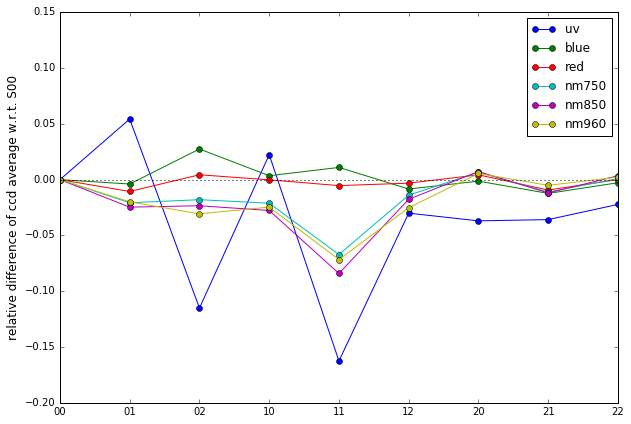

In [156]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,7))
for i,led in enumerate(led_names):
    ax.plot(avg[i,:]/avg[i,:][0]-1, marker='o', label=led)
ax.set_xticklabels(slot_names)
ax.set_ylim(-0.20,0.15)
ax.set_ylabel('relative difference of ccd average w.r.t. S00', size='large')
ax.axhline(0.0, color='k', ls=':')
ax.legend()
fig.savefig('ccob_rel.png')

In [140]:
print avg
print avg[2,:]

[[ 85889.51318359  90548.35742188  76003.34130859  87801.62988281
   71930.96484375  83306.95068359  82713.6875      82811.41015625
   83978.84667969]
 [ 62012.08935547  61765.84790039  63712.24853516  62227.94238281
   62688.49365234  61487.49951172  61927.28051758  61244.87036133
   61837.89624023]
 [ 72907.25195312  72130.75537109  73222.68310547  72891.84619141
   72514.36572266  72674.06347656  73218.11669922  72224.50830078
   72911.41699219]
 [ 56144.07543945  54977.96435547  55134.32446289  54955.80078125
   52374.82836914  55359.79980469  56513.21411133  55517.12524414
   56195.30004883]
 [ 63149.65405273  61590.81835938  61670.39648438  61402.67773438
   57839.58935547  62036.2890625   63607.86987305  62394.33129883
   63365.00488281]
 [ 73752.17480469  72282.07910156  71488.54296875  71934.52294922
   68470.27978516  71894.12841797  74157.05957031  73371.35449219
   73915.50927734]]
[ 72907.25195312  72130.75537109  73222.68310547  72891.84619141
  72514.36572266  72674.0634

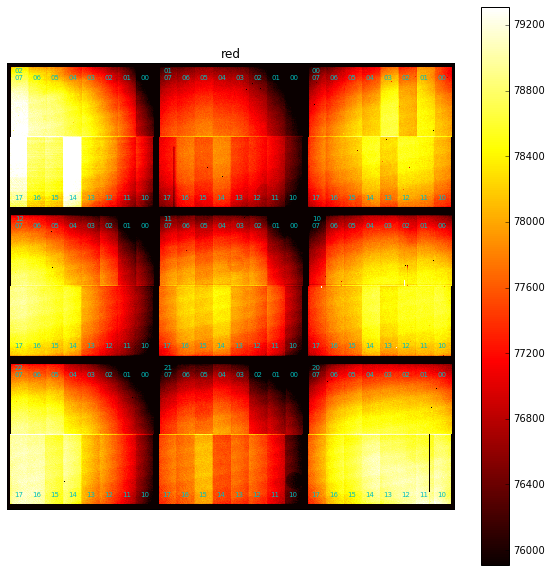

In [17]:
fig_corr = dd_corr.plot(nsig=2, title = config['led_name'])
fig_corr.savefig('corr_mosaic_'+config['led_name']+'.png')
fig_corr.savefig('corr_mosaic_'+config['led_name']+'.pdf')

In [20]:
dd = raft.RaftMosaic(fits_files_dict, bias_subtract=False)

processing 02_CCOB_red_0.012A_0.06s_X258_Y150_0000_20171215015049.fits
processing 10_CCOB_red_0.012A_0.06s_X300_Y234_0000_20171215014154.fits
processing 00_CCOB_red_0.012A_0.06s_X258_Y234_0000_20171215014518.fits
processing 01_CCOB_red_0.012A_0.06s_X258_Y192_0000_20171215014750.fits
processing 20_CCOB_red_0.012A_0.06s_X342_Y234_0000_20171215020016.fits
processing 21_CCOB_red_0.012A_0.06s_X342_Y192_0000_20171215015708.fits
processing 22_CCOB_red_0.012A_0.06s_X342_Y150_0000_20171215015344.fits
processing 12_CCOB_red_0.012A_0.06s_X300_Y150_0000_20171215013741.fits
processing 11_CCOB_red_0.012A_0.06s_X300_Y192_0000_20171215013334.fits


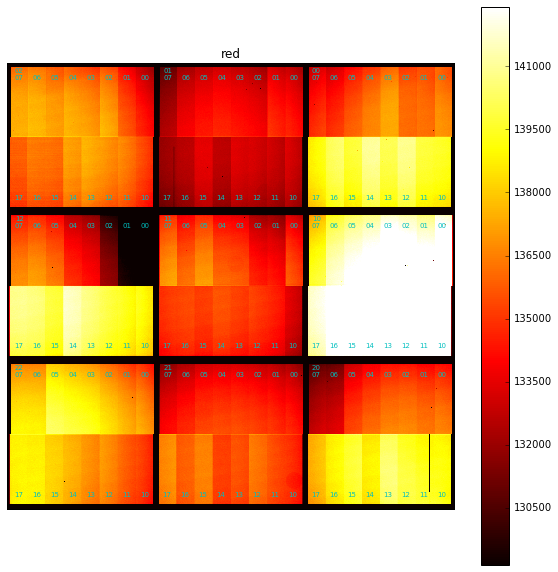

In [21]:
fig_raw = dd.plot(nsig=2, title = config['led_name'])
fig_raw.savefig(os.path.join(config['tmp_dir'],'raw_mosaic'+config['led_name']+'.png'))
fig_raw.savefig(os.path.join(config['tmp_dir'],'raw_mosaic'+config['led_name']+'.pdf'))

['/home/combet/tmp/ccd20_beam_reconstruction_red.fits', '/home/combet/tmp/ccd21_beam_reconstruction_red.fits', '/home/combet/tmp/ccd12_beam_reconstruction_red.fits', '/home/combet/tmp/ccd01_beam_reconstruction_red.fits', '/home/combet/tmp/ccd11_beam_reconstruction_red.fits', '/home/combet/tmp/ccd00_beam_reconstruction_red.fits', '/home/combet/tmp/ccd22_beam_reconstruction_red.fits', '/home/combet/tmp/ccd10_beam_reconstruction_red.fits', '/home/combet/tmp/ccd02_beam_reconstruction_red.fits']


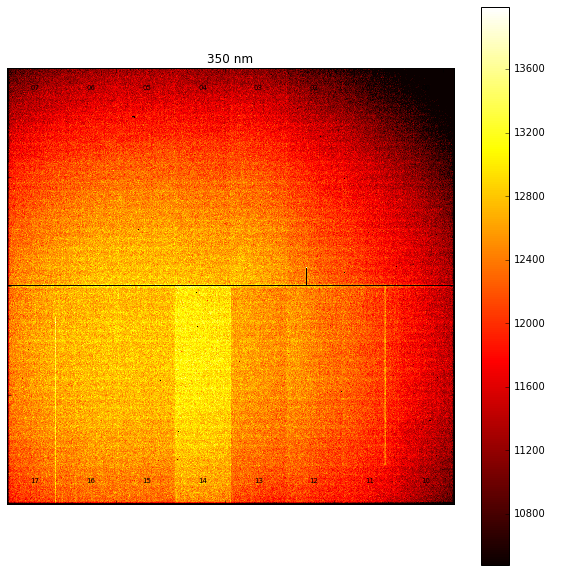

In [22]:
file_list=glob.glob(os.path.join(config['tmp_dir'],'*beam_reconstruction_'+config['led_name']+'.fits'))
print file_list
imutils.fits_mean_file(file_list, os.path.join(config['tmp_dir'],'mean_beam.fits'))
mean_beam = sensorTest.MaskedCCD(os.path.join(config['tmp_dir'],'mean_beam.fits'))
sensorTest.plot_flat(os.path.join(config['tmp_dir'],'mean_beam.fits'))


In [24]:
def fill_seg_dict(ccd):
    seg_dict_slot = {}
    for amp in ccd.keys():
        datasec = [ccd.amp_geom[amp]['DATASEC'].strip('[]').split(',')[0].split(':')[0],
                   ccd.amp_geom[amp]['DATASEC'].strip('[]').split(',')[0].split(':')[1],
                   ccd.amp_geom[amp]['DATASEC'].strip('[]').split(',')[1].split(':')[0],
                   ccd.amp_geom[amp]['DATASEC'].strip('[]').split(',')[1].split(':')[1]]
        detsec = [ccd.amp_geom[amp]['DETSEC'].strip('[]').split(',')[0].split(':')[0],
                  ccd.amp_geom[amp]['DETSEC'].strip('[]').split(',')[0].split(':')[1],
                  ccd.amp_geom[amp]['DETSEC'].strip('[]').split(',')[1].split(':')[0],
                  ccd.amp_geom[amp]['DETSEC'].strip('[]').split(',')[1].split(':')[1]]
        detsize = [ccd.amp_geom[amp]['DETSIZE'].strip('[]').split(',')[0].split(':')[0],                      
                   ccd.amp_geom[amp]['DETSIZE'].strip('[]').split(',')[0].split(':')[1],
                   ccd.amp_geom[amp]['DETSIZE'].strip('[]').split(',')[1].split(':')[0],
                   ccd.amp_geom[amp]['DETSIZE'].strip('[]').split(',')[1].split(':')[1]]
     
        seg_dict_slot[amp] = {'datasec':list(map(int,datasec)),
                         'detsec':list(map(int,detsec)),
                         'detsize':list(map(int,detsize))
                        }
    return seg_dict_slot


In [25]:
def make_ccd_image(seg_dict, ccd_dict, slot):
    img_tot = np.empty(shape=(seg_dict[slot][1]['detsize'][3],seg_dict[slot][1]['detsize'][1]))
    for seg in seg_dict[slot].keys():
        xmin = seg_dict[slot][seg]['datasec'][0]
        xmax = seg_dict[slot][seg]['datasec'][1]
        ymin = seg_dict[slot][seg]['datasec'][2]
        ymax = seg_dict[slot][seg]['datasec'][3]
        xmin_detset = seg_dict[slot][seg]['detsec'][0]
        xmax_detset = seg_dict[slot][seg]['detsec'][1]
        ymin_detset = seg_dict[slot][seg]['detsec'][2]
        ymax_detset = seg_dict[slot][seg]['detsec'][3]
    
        if (xmin_detset < xmax_detset) & (ymin_detset < ymax_detset):
                img_tot[ymin_detset-1:ymax_detset-1,xmin_detset-1:xmax_detset-1] = \
                  ccd_dict[slot][seg].getArrays()[0][ymin-1:ymax-1,xmin-1:xmax-1]

        if (xmin_detset < xmax_detset) & (ymin_detset > ymax_detset):
                img_tot[ymax_detset-1:ymin_detset-1,xmin_detset-1:xmax_detset-1] =\
                  ccd_dict[slot][seg].getArrays()[0][ymin-1:ymax-1,xmin-1:xmax-1][::-1,:]

        if (xmin_detset > xmax_detset) & (ymin_detset < ymax_detset):
                img_tot[ymin_detset-1:ymax_detset-1,xmax_detset-1:xmin_detset-1] =\
                  ccd_dict[slot][seg].getArrays()[0][ymin-1:ymax-1,xmin-1:xmax-1][:,::-1]

        if (xmin_detset > xmax_detset) & (ymin_detset > ymax_detset):
                img_tot[ymax_detset-1:ymin_detset-1,xmax_detset-1:xmin_detset-1] =\
                  ccd_dict[slot][seg].getArrays()[0][ymin-1:ymax-1,xmin-1:xmax-1][::-1,::-1]

    return img_tot


In [57]:
tmp_dir = '/home/combet/tmp/'
ccd_dict_corr = {}
for slot in slot_names:
    ccd_dict_corr[slot] = sensorTest.MaskedCCD(fits_files_dict_corr[slot])
seg_dict = {slot:fill_seg_dict(ccd_dict_corr[slot]) for slot in slot_names}

for i,slot in enumerate(slot_names):
    if i==0 :
        image = make_ccd_image(seg_dict, ccd_dict_corr, slot)
        ref = np.mean(image)
    else:
        tmp = make_ccd_image(seg_dict, ccd_dict_corr, slot)
        image += tmp*ref/np.mean(tmp)
image/=float(len(slot_names))        

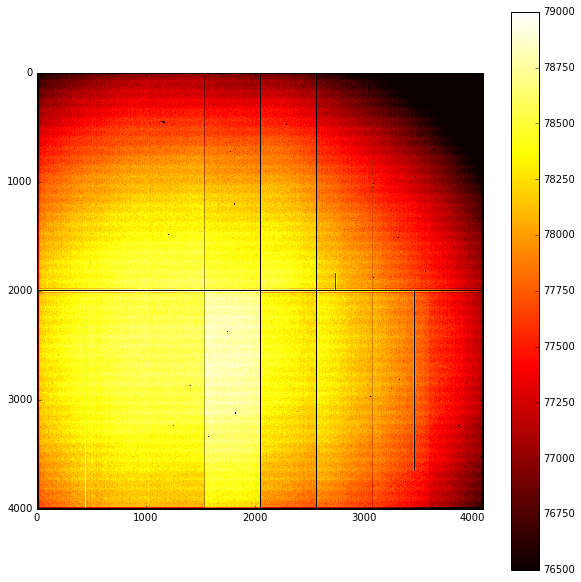

In [68]:
import scipy.ndimage as ndimage
im = ndimage.uniform_filter(image, (3, 3))
plt.imshow(im[::-1,::-1], cmap='hot', vmin=76500, vmax=79000)
plt.colorbar()

(76000, 80000)

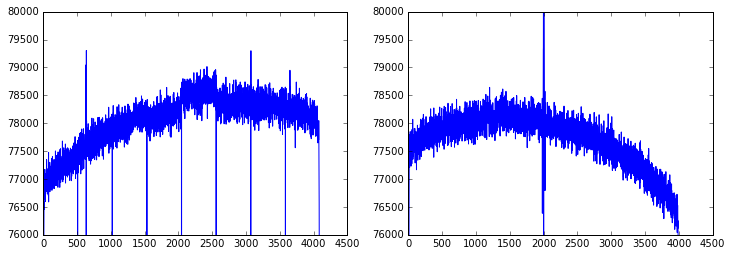

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axes[0].plot(image[1500,:])
axes[0].set_ylim(76000,80000)
axes[1].plot(image[:,1500])
axes[1].set_ylim(76000,80000)

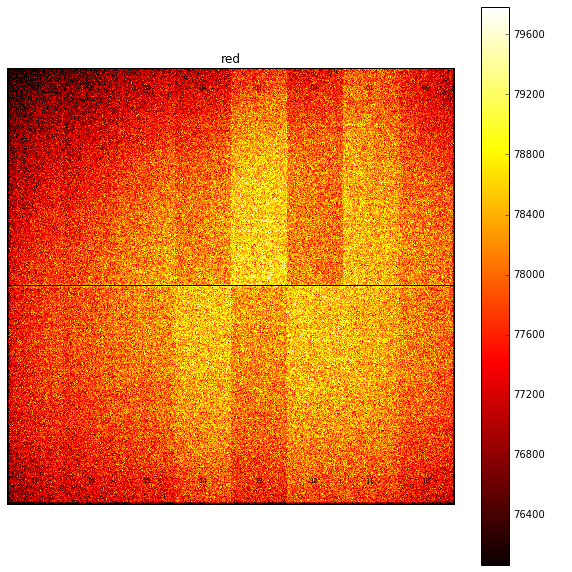

In [29]:
sensorTest.plot_flat(fits_files_dict['00'], gains=gains_dict['00'], title=config['led_name'])


In [30]:
image = make_ccd_image(seg_dict, ccd_dict_corr, '00')

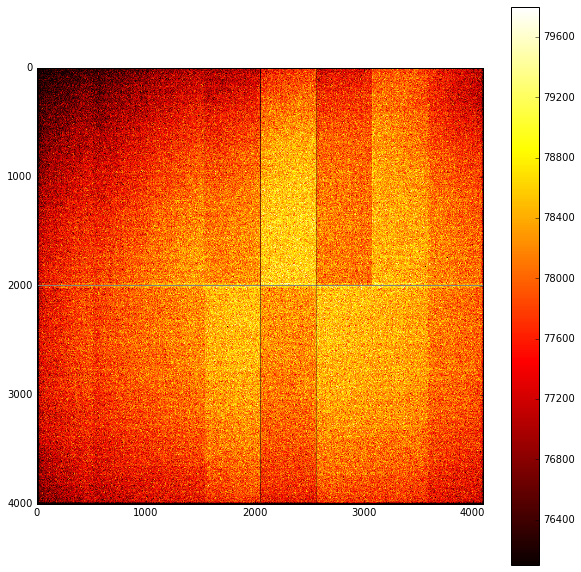

In [37]:
plt.imshow(image[::-1,::-1], cmap='hot', vmin=76100, vmax=79800)
plt.colorbar()

In [49]:
im2 = ndimage.uniform_filter(image, 10)

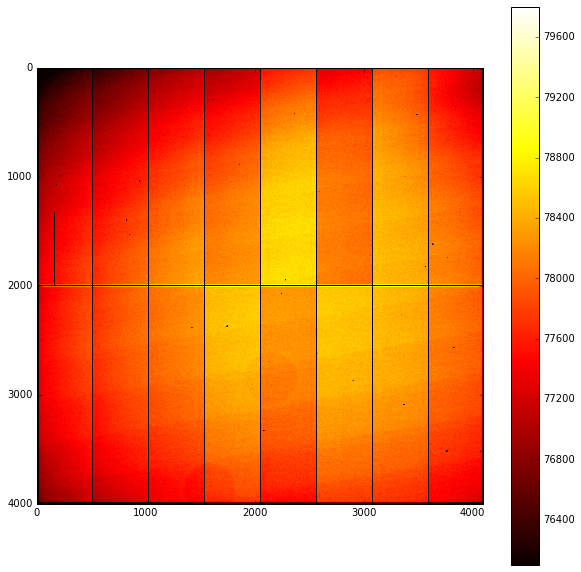

In [50]:
plt.imshow(im2[::-1,::-1], cmap='hot', vmin=76100, vmax=79800)
plt.colorbar()